In [ ]:
import numpy as np
import numpy.linalg as la
from MDAnalysis import Universe


def gen_cov(uni, atom1, atom2, length, shift=False):
    """
    params:
        uni: MDAnalysis Universe object.
        atom1, atom2: Atom names (e.g., 'N', 'C', 'CA', 'CB', etc.).
        length: Expected number of residues in the structure.
        shift: Boolean, True when calculating shifted vectors (e.g., N-C across residues).
    """
    # Load the structure into MDAnalysis
    u = uni

    # Extract coordinates for the specified atoms
    atom1_sel = u.select_atoms(f"resid 1:{length} and name {atom1}")
    atom2_sel = u.select_atoms(f"resid 1:{length} and name {atom2}")

    # Ensure both selections have matching residue indices
    atom1_resids = [atom.resid for atom in atom1_sel]
    atom2_resids = [atom.resid for atom in atom2_sel]
    index_atom1 = [i for i in range(1, length + 1) if i in atom1_resids]
    index_atom2 = [i for i in range(1, length + 1) if i in atom2_resids]

    index = sorted(set(index_atom1).union(set(index_atom2)))

    # Extract coordinates as numpy arrays
    atom1_coords = atom1_sel.positions
    atom2_coords = atom2_sel.positions

    # account for terminal residues

    if shift and atom1 == 'N' and atom2 == 'C':
        bond_vec = atom1_coords[1:] - atom2_coords[:-1]
        index = index_atom2[:-1]
    elif shift and atom1 == 'C' and atom2 == 'N':
        bond_vec = atom2_coords[1:] - atom1_coords[:-1]
        index = index_atom1[:-1]
    else:
        bond_vec = atom1_coords[:len(atom2_coords)] - atom2_coords
        index = index_atom2

    # Normalize bond vectors
    normalized_bond_vec = bond_vec / la.norm(bond_vec, axis=1).reshape(-1, 1)

    # Compute cosine similarity matrix
    cos = normalized_bond_vec @ normalized_bond_vec.T

    # Compute covariance matrix
    cov = 0.5 * (3 * cos**2 - 1)

    return np.array(index), cov

In [2]:
#/usres/yunyao_1/Dropbox/KcsA/kcsa_0111/snapshots
import os
import MDAnalysis
pdb_dir='/Users/yunyao_1/Dropbox/KcsA/kcsa_100ns_0111/snapshots_prot'
pdb_container={}
for pdb in os.listdir(pdb_dir):
    pdb_f=os.path.join(pdb_dir,pdb)
    #MDAnalysis.Universe(pdb_f)
    if 'pdb' in pdb_f:
        pdb_container[pdb[23:].rstrip('.pdb')]=MDAnalysis.Universe(pdb_f)

In [3]:
#pdb_container['1'].residues.resids
# test gen_cov
# index,cov=gen_cov(pdb_container['1'],'O','C',160)
# cov.shape

ranked_pdb_container = dict(sorted(pdb_container.items(), key=lambda x: int(x[0]), reverse=False))
print(ranked_pdb_container.keys())

# for key,pdb_uni in pdb_container.items()[:3]:
#     print(pdb_uni)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

In [13]:
# syntax to select amind proton
print(pdb_container['1'].select_atoms('name H or name H1').positions.shape)
# we remove terminal H1 as well
print(pdb_container['1'].select_atoms('name H').positions.shape)
# why 396 instead of 412?
# because some residues do not have amide proton, e.g., proline

(400, 3)
(396, 3)


In [11]:
#atom1_c = 'N'
from tqdm import tqdm
#atom2_c = 'H'
length_c = 412
shift_c=False
cov_ensemble_nh = []
for i, (key, values) in tqdm(zip(range(1000), ranked_pdb_container.items())):
    cov_ensemble_nh.append(gen_cov(values,'N','H',length_c,shift=shift_c)[1])

1000it [00:14, 68.86it/s]


In [12]:
cov_ensemble_nh = np.array(cov_ensemble_nh)
cov_ensemble_nh.shape

(1000, 396, 396)

In [7]:
def block_ired_sep(cov_ensemble,block_size,index,total_time=1000,M=0):
    i = 0
    kappa = []
    while i+block_size <= total_time:
        kappa_tmp =[]
        angle = np.array(cov_ensemble[i:i+block_size]).mean(axis=0)
        w, v = la.eig(angle)
        for m in range(len(index)):
#             print(v[:,m].T @ v[:,m])
            kappak=[]
            kappak.append(1/len(index)*np.exp(-(v[:,m]**2 * np.log(v[:,m]**2)).sum()))
            kappa_tmp.append(kappak)
        kappa.append(kappa_tmp) 
        i += block_size
    return np.array(kappa).mean(axis=2)

# NH order parameter for amide HN bone vector

In [15]:
from ired import block_ired
index_c=gen_cov(pdb_container['1'],'N','H',412)[0]
print(index_c)
block= [10,20,50,100,200,500]
s2_c_list = [block_ired(cov_ensemble_nh,block_size,index_c,total_time=1000,M=5)[0] for block_size in block]
err_c_list = [block_ired(cov_ensemble_nh,block_size,index_c,total_time=1000,M=5)[2] for block_size in block]

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38
  39  40  41  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 138 139 140 141 142 143 144 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 241 242 243 244
 245 246 247 249 250 251 252 253 254 255 256 257 25

In [17]:
index_c_group= index_c.reshape(4, -1)
print(index_c_group[0,:])

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38
  39  40  41  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103]


In [ ]:
print(len(s2_c_list))
print(s2_c_list[0].shape)
s2_c_list_array = np.array(s2_c_list)
err_c_list_array = np.array(err_c_list)

print(s2_c_list_array.shape)



6
(396,)
(6, 396)


In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# based on the index_c to assign residue groups

# residue index:
# we first divide the whole index_c into 4 groups according to four monomers
# we then add residue number accordingly for each group, when in first rank, shift it by 21. Caution: the first residue is missing
# for the second rank, shift it by 21+103; for the third rank, shift it by 21+103*2; for the fourth rank, shift it by 21+103*3
# we need to account for the missing residues in the index_c as well
residue_shift = [21, 21-103, 21-103*2, 21-103*3]
# resize the index_c for each monomer
index_c_group= index_c.reshape(4, -1)
index_c_adjusted = [index_c_group[i,:]+residue_shift[i] for i in range(4)]

# add NA for missing residues
# Full range of residues
import numpy as np

full_range = np.arange(1, 413)
s2_c_list_array = np.array(s2_c_list)  # shape (6, 396)
err_c_list_array = np.array(err_c_list)

n_analysis, n_residues_present = s2_c_list_array.shape

# Aligned arrays: rows = n_analysis, columns = full_range (412)
s2_c_aligned = np.full((n_analysis, len(full_range)), np.nan, dtype=float)
s2_c_err_aligned = np.full((n_analysis, len(full_range)), np.nan, dtype=float)

# Map columns from index_c to full_range
for i_analysis in range(n_analysis):
    for col_idx, residue_idx in enumerate(index_c):
        if 1 <= residue_idx <= len(full_range):
            # Assign column value
            s2_c_aligned[i_analysis, residue_idx-1] = s2_c_list_array[i_analysis, col_idx]
            s2_c_err_aligned[i_analysis, residue_idx-1] = err_c_list_array[i_analysis, col_idx]













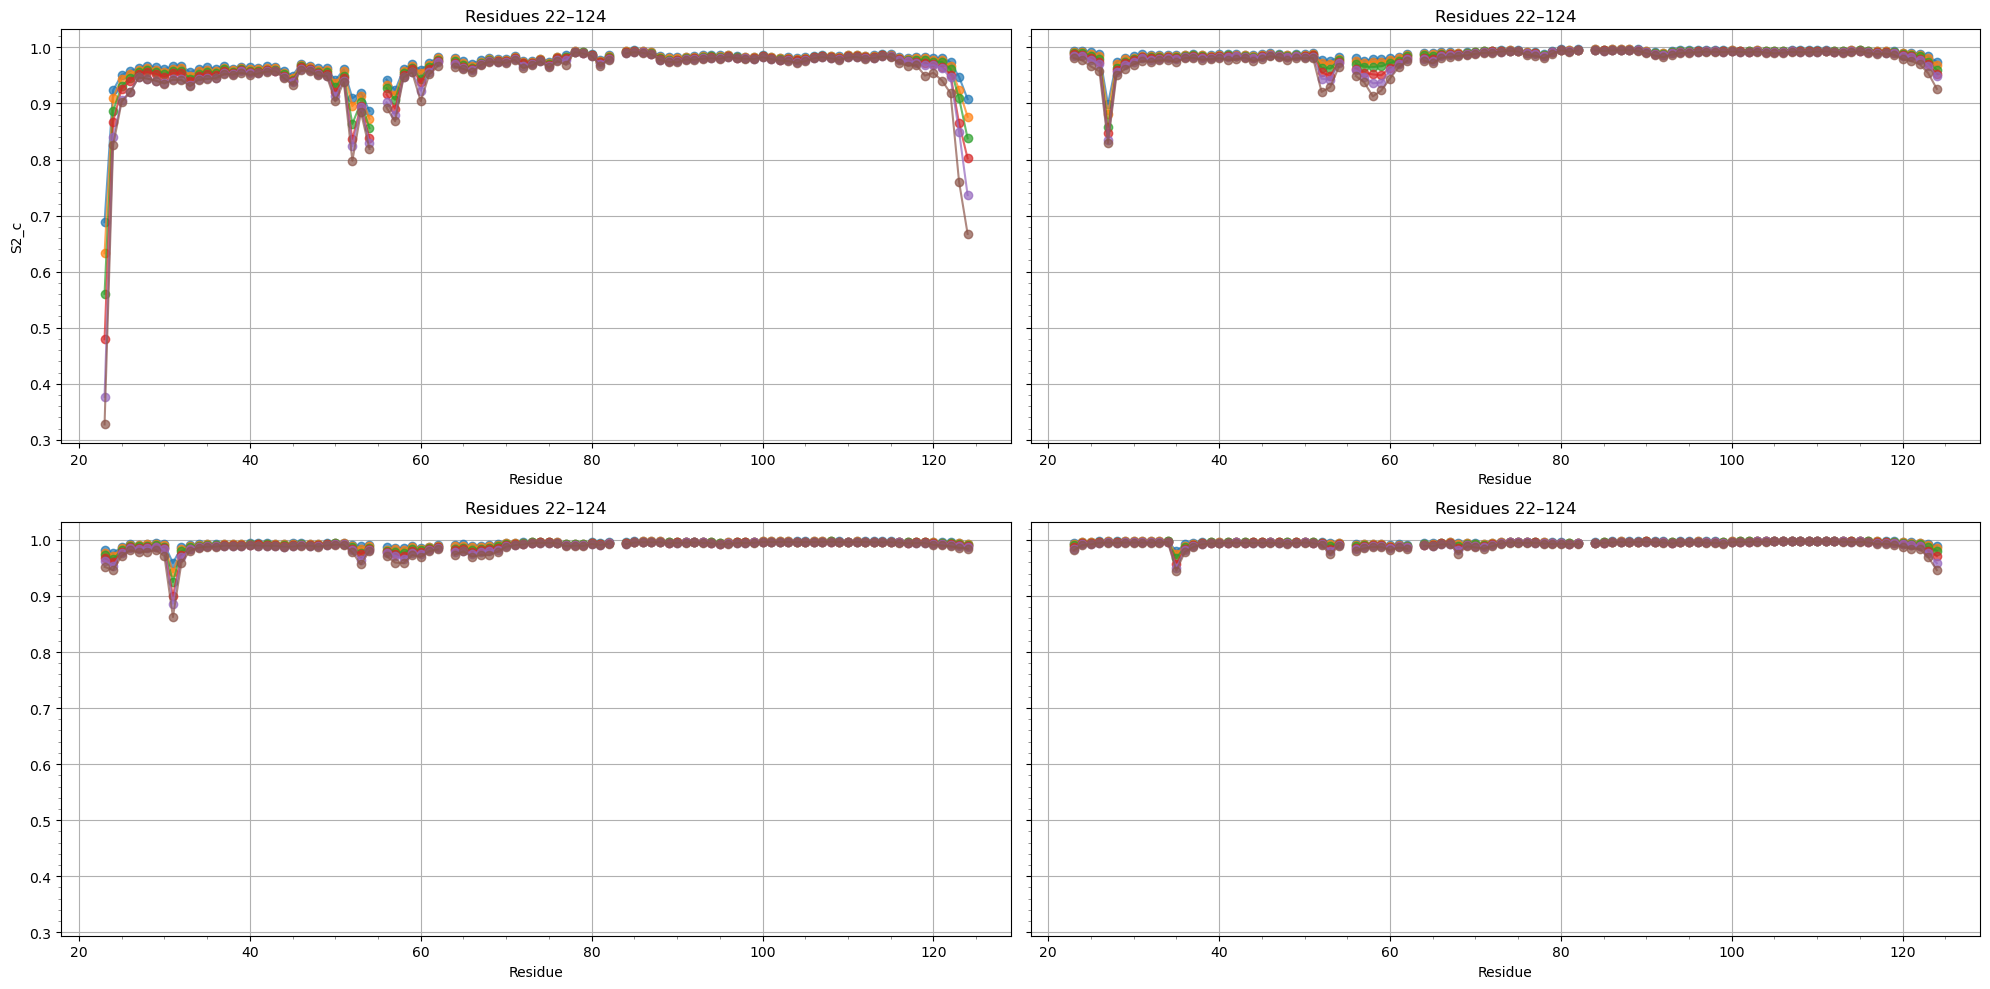

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Example: s2_c_aligned shape (n_analysis, 412)
# index_c_adjusted[0] is a list of length 412 (full residues)
x_full = np.array(full_range)  # full x-axis for 412 residues

n_quarters = 4
res_per_quarter = len(x_full) // n_quarters  # 412/4 = 103

fig, axes = plt.subplots(2, n_quarters//2, figsize=(20, 10), sharey=True)

# Plot each quarter
for q in range(n_quarters):
    x = range(22,125)
    for row in range(s2_c_aligned.shape[0]):
        y= s2_c_aligned[row,0+q*103:103+q*103]
        axes[q//2, q%2].plot(x, y, marker='o', linestyle='-', alpha=0.7)
    axes[q//2, q%2].set_title(f"Residues {x[0]}–{x[-1]}")
    axes[q//2, q%2].set_xlabel("Residue")
    axes[q//2, q%2].grid(True)
    axes[q//2, q%2].grid(True)
    axes[q//2, q%2].minorticks_on()  # enable minor ticks
    axes[q//2, q%2].tick_params(axis='both', which='minor', length=2, color='gray')

axes[0, 0].set_ylabel("S2_c")  # label y-axis only on first subplot
plt.tight_layout()
plt.show()
